# Key Analyses
This document is for some additional analyses and prettifying, summarizing existing analyses for the purpose of publishing a blog.

In [853]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context("notebook") # setting the scale of graphs
sns.set_style("darkgrid") # setting the style of graphs

In [854]:
#loading data
df = pd.read_csv('data/profit_data.csv', index_col = 0)

In [855]:
# simplified df (keeping only what I need)
df = df[['title', 'new_genre', 'primary_genre', 'secondary_genre', 'MPAA', 'month', 'year', 'popularity', 'avg_rating_imdb',
   'production_budget', 'domestic_gross', 'worldwide_gross', 'domestic_gross_z', 'worldwide_gross_z']].copy()

In [856]:
df.rename(columns={'new_genre': 'genre', 'avg_rating_imdb': 'avg_rating', 'production_budget': 'budget', 
                  'domestic_gross':'dom_gross', 'worldwide_gross': 'glob_gross'}, inplace = True)

In [857]:
df.genre = np.where(df.title.isin(['kung fu panda 2','kung fu panda 3', 'incredibles 2', 
                                  'big hero 6', 'how to train your dragon 2', 'the croods', 
                                   'puss in boots', 'the lego movie', 'how to train your dragon: the hidden world']), 'Animation', df.genre)

In [858]:
df[df.title.str.contains("incredibles")]

,title,genre,primary_genre,secondary_genre,MPAA,month,year,popularity,avg_rating,budget,dom_gross,glob_gross,domestic_gross_z,worldwide_gross_z
1638,incredibles 2,Animation,Action,Adventure,PG,6,2018,30.495,7.7,200.0,608.58,1242.52,6.04268,4.319055


For genres with less than 10 data points, we will try to reassign to appropriate genre with higher data counts.

In [859]:
#df.groupby('primary_genre').secondary_genre.value_counts().unstack()

Shuffling some of the genre information.  
I'll follow couple rules I set as below. 
1. If primary or secondary genre is horror, the movie is horror.
2. If primary or secondary genre is documentary, the movie is documentary.
3. If primary or secondary genre is animation, the movie is animation.
4. If primary or secondary genre is family, the movie is family.
5. If non-horror movie is 'crime drama, 'crime mystery' or 'thriller', it should be 'Crime_Mystery_Thriller'.

In [860]:
conditions = [
    (df.primary_genre == 'Horror') | (df.secondary_genre == 'Horror'), 
    (df.primary_genre == 'Documentary') | (df.secondary_genre == 'Documentary'), 
    (df.primary_genre == 'Animation') | (df.secondary_genre == 'Animation'), 
    (df.primary_genre == 'Family') | (df.secondary_genre == 'Family'), 
    ((df.primary_genre == 'Crime') & (df.secondary_genre.isin(['Drama', 'Mystery']))) | (df.secondary_genre == 'Thriller')
]
vals = ['Horror', 'Documentary', 'Animation', 'Family', 'Crime_Mystery_Thriller']
df['genre'] = np.select(conditions, vals, default = df.genre)

others = ['Documentary', 'Romance', 'Sci-Fi', 'Fantasy', 'Mystery']
df['genre'] =  np.where(df.genre.isin(others), 'Others', df.genre)

In [861]:
# drop movies with 0 revenue
df = df[(df.glob_gross != 0) & (df.dom_gross != 0)]
# drop 'others' movies
df = df[df.genre != 'Others']

### Distribution of gross revenue

Let's start looking at the distribution of overall gross revenues. 

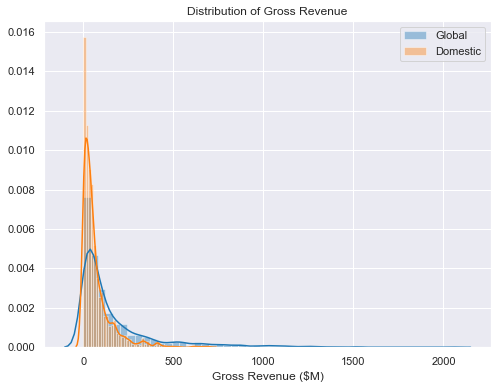

In [931]:
fig = plt.figure(figsize = (8, 6))
sns.distplot(df.glob_gross, label = 'Global')
sns.distplot(df.dom_gross, label = "Domestic")
plt.title("Distribution of Gross Revenue")
plt.xlabel("Gross Revenue ($M)")
plt.legend()

#fig.savefig("PNG/BLOG/dist_gross.png")

plt.show()

As expected, it is strongly right skewed. Let's take the log of revenues to look at the trend more closely.

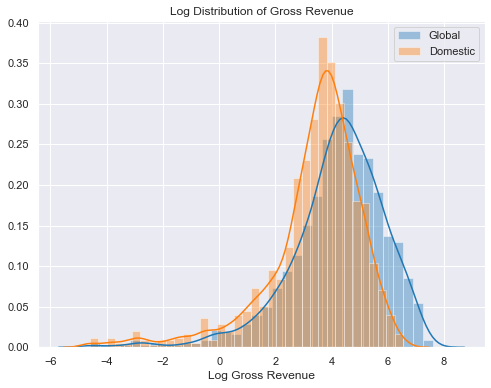

In [932]:
fig = plt.figure(figsize = (8, 6))
sns.distplot(np.log(df.glob_gross), label = 'Global')
sns.distplot(np.log(df.dom_gross), label = "Domestic")
plt.title("Log Distribution of Gross Revenue")
plt.xlabel("Log Gross Revenue")
plt.legend()

#fig.savefig("PNG/BLOG/dist_gross_ln.png")

plt.show()

It seems like global market yields on average higher revenues. Not surprising, let's look at the relationship between budget and revenue.

### Budget to Revenue

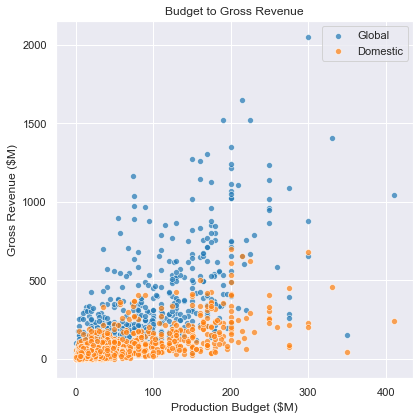

In [867]:
fig = plt.figure(figsize = (6, 6))
sns.scatterplot(x = 'budget', y = 'glob_gross', label = "Global", alpha = 0.7, data = df)
sns.scatterplot(x = 'budget', y = 'dom_gross', label = "Domestic", alpha = 0.7, data = df)
plt.title("Budget to Gross Revenue")
plt.legend()
plt.ylabel("Gross Revenue ($M)")
plt.xlabel("Production Budget ($M)")
plt.tight_layout()

#plt.savefig("PNG/BLOG/budget_gross.png")

plt.show()

It seems like high budget does not necessarily lead to high revenue especially in the domestic market. Also some movies seem to yield high revenues with relatively lower budget when it targets global market. Let's look closer into which genres might return the most profit (here I'm assuming that the "profit" is gross revenue minus the budget. But we should take into consideration that since what's included in the production budget in movie industry can be quite unclear, we might be using the term profit liberally. We will think of this term as more of a relationship between the revenue and budget than the actual profit.

### Distribution of Genre

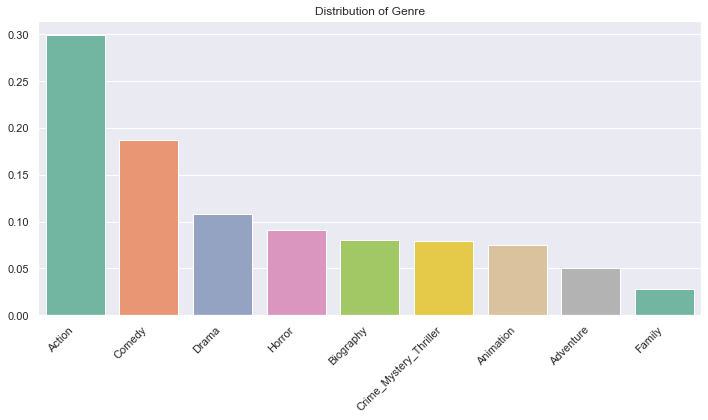

In [955]:
Y = df.genre.value_counts(normalize = True)
X = Y.index

fig = plt.figure(figsize = (10, 6))
g = sns.barplot(X, Y, palette = "Set2")

g.set(title = 'Distribution of Genre', ylabel = "", xlabel = "")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#fig.savefig("PNG/BLOG/genre_distribution.png")

plt.show()


### Percent return per investment per genre

In [870]:
df['gross_p_cost'] = df['glob_gross'] / df['budget']

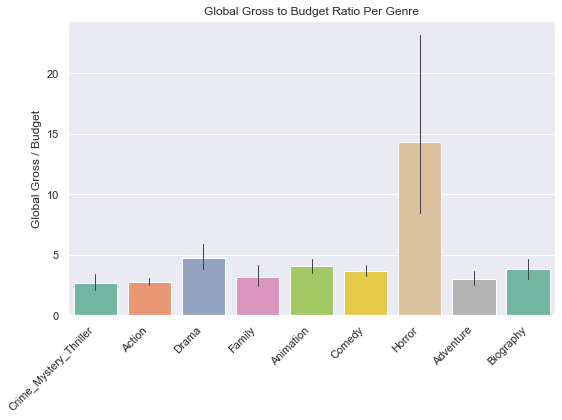

In [958]:
fig = plt.figure(figsize = (8, 6))
g = sns.barplot(x = 'genre', y = 'gross_p_cost', data = df, 
                palette="Set2", errwidth = 1)
g.set(title = 'Global Gross to Budget Ratio Per Genre', 
      ylabel = "Global Gross / Budget", xlabel = "")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#fig.savefig("PNG/BLOG/return_ratio_genre.png")

plt.show()

Looking at the global gross revenue per budget ratio, horror movies seem to make the most return per investment. But this does not necessarily mean that horror movies bring the most profit.

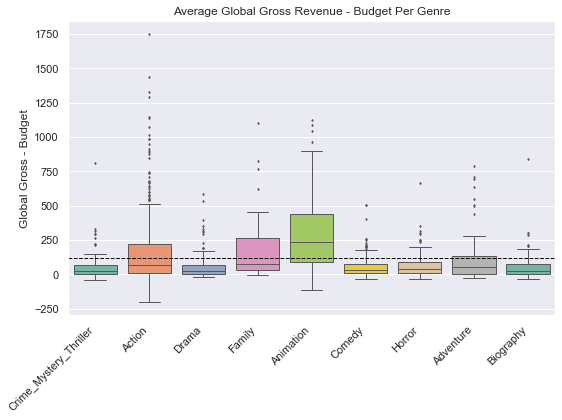

In [952]:
# term 'profit' used liberally
df['profit'] = df['glob_gross'] - df['budget']

fig = plt.figure(figsize = (8, 6))
g = sns.boxplot(x = 'genre', y = 'profit', data = df, 
                palette="Set2", linewidth = 1, fliersize= 1.5)
g.set(title = 'Average Global Gross Revenue - Budget Per Genre', 
      ylabel = "Global Gross - Budget", xlabel = "")

plt.axhline(df.profit.mean(), ls = '--', lw = 1, color = 'black')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#fig.savefig("PNG/BLOG/profit_genre.png")

plt.show()

In fact, the movies that tend to yield the profit that's above average is animation. Higher percent of action and family also yields higher profit, but rather rarely. So it's likely that horror films cost little to make and the percent return per investment is great, and it's a low risk. Let's dive deeper into it. 

## Look more closely

### Budget

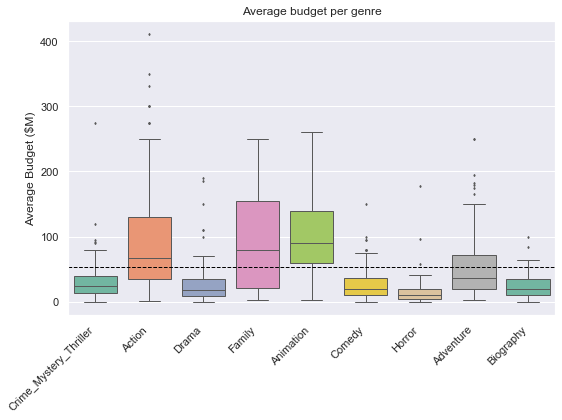

In [951]:
fig = plt.figure(figsize = (8, 6))
g = sns.boxplot(x = 'genre', y = 'budget', data = df, 
                palette="Set2", linewidth = 1, fliersize= 1.5)
g.set(title = 'Average budget per genre', 
      ylabel = "Average Budget ($M)", xlabel = "")

plt.axhline(df.budget.mean(), ls='--', lw = 1, color = 'black')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#fig.savefig("PNG/BLOG/avg_budget_genre.png")

plt.show()

Action, family, and animation are usually high budget films. 

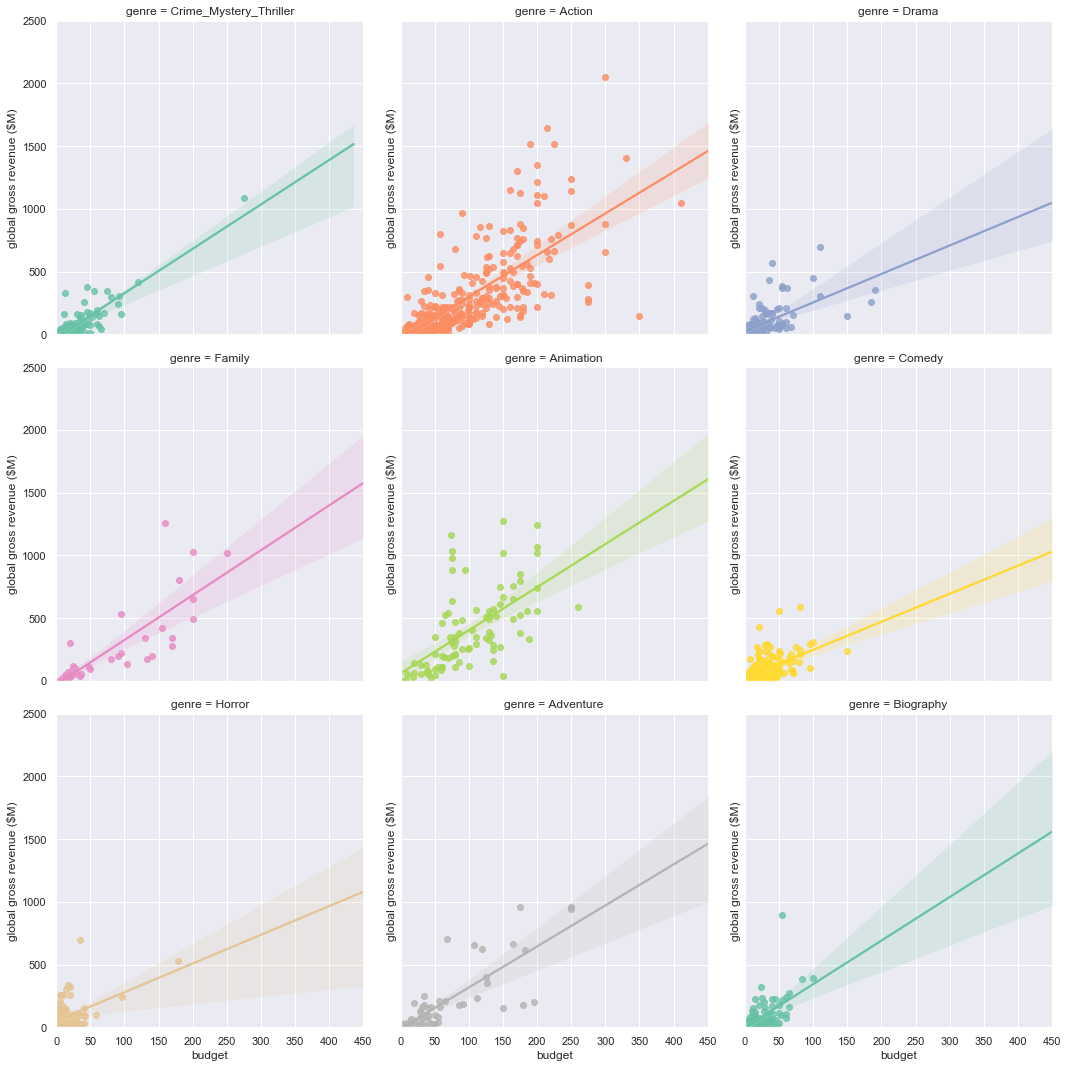

In [961]:
g = sns.lmplot(x = 'budget', y = 'glob_gross', col = 'genre', col_wrap = 3, 
               hue = 'genre', data = df, palette="Set2", truncate=False)

g.set(xlim = (0, 450), ylim = (0, 2500), ylabel = "global gross revenue ($M)")
plt.tight_layout()

#g.savefig("PNG/BLOG/budget_glob_genre.png")

plt.show()

Looking at the linear model and scatter plot, it's clear that with a very few exceptions, horror movies are low cost and never quite make a lot of revenues. Also high average profit for adventures seem like from a handful of rare successes. It seems like feasible money-makers are action, animation and family films. Action seems to have more strong correlation between budget and gross, while animation seems to allow some of the high success with relatively lower budget. 

Let's look at the correlation.

In [879]:
for g in df['genre'].unique():
    corr = df[df.genre == g]['budget'].corr(df[df.genre == g]['glob_gross'])
    print(f"{g}: {round(corr, 2)}")

Crime_Mystery_Thriller: 0.86
Action: 0.74
Drama: 0.6
Family: 0.8
Animation: 0.6
Comedy: 0.56
Horror: 0.47
Adventure: 0.81
Biography: 0.55


As suspected, action seems to have more linear relationship between budget and global gross revenue than animation.

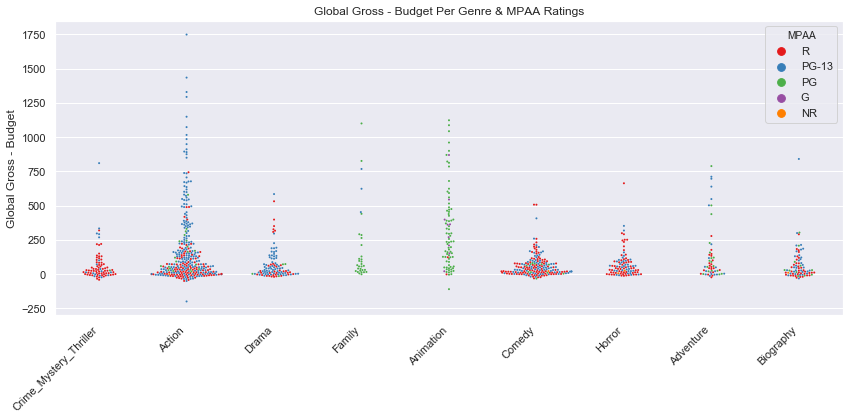

In [924]:
fig = plt.figure(figsize = (12, 6))

g = sns.swarmplot(x = 'genre', y = 'profit', hue = 'MPAA', 
                  data = df, size = 2, palette="Set1")

g.set(title = 'Global Gross - Budget Per Genre & MPAA Ratings', 
      ylabel = "Global Gross - Budget", xlabel = "")

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

#fig.savefig("PNG/BLOG/profit_genre_MPAA.png")

plt.show()

Yes, it seems like family and animations are usually PG rated, while action is PG-13 and R rated. The rare successes in action seems to come mostly from PG-13 films. R-rated films don't do as well, which is likely due to limited number of target audience.  

But the profit is not everything. As a brand new studio, we want to build a reputation and elevate our brand image to other established brand studio. This requires making reputable or award-worthy movies, and popular movies that go viral. Let's see what movies tend to earn this status.

### Ratings per movie

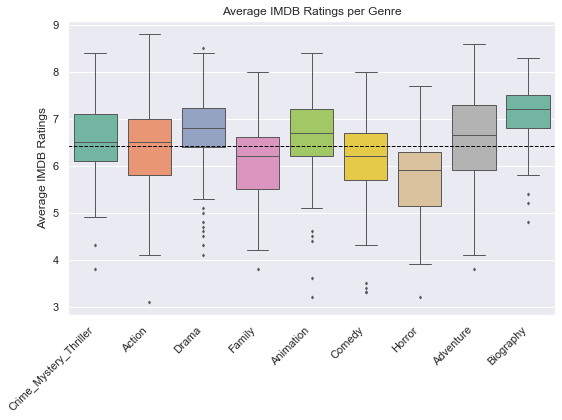

In [963]:
fig = plt.figure(figsize = (8, 6))
g = sns.boxplot(x = 'genre', y = 'avg_rating', data = df, 
                palette="Set2", linewidth = 1, fliersize = 2)
g.set(title = 'Average IMDB Ratings per Genre', 
      ylabel = "Average IMDB Ratings", xlabel = "")

plt.axhline(df.avg_rating.mean(), ls='--', lw = 1, color = 'black')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#fig.savefig("PNG/BLOG/rating_genre.png")

plt.show()

Looking at IMDB ratings, a majority of horror movies don't get high ratings, while majority of biography or drama film tends to get higher ratings. We should look more in detail which type of biography or drama films are worth investing into. But all time winner seems like an animation, which often yields high revenue and high ratings. One downside is that award opportunities for animation is relatively slim.

### Popularity per genre

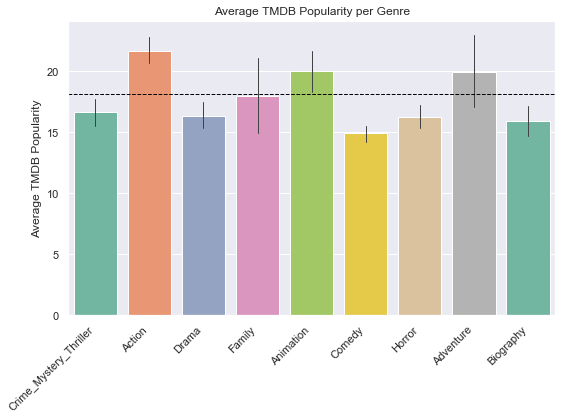

In [922]:
fig = plt.figure(figsize = (8, 6))

g = sns.barplot(x = 'genre', y = 'popularity', data = df, 
                palette="Set2", errwidth = 1)
g.set(title = 'Average TMDB Popularity per Genre', 
      ylabel = "Average TMDB Popularity", xlabel = "")

plt.axhline(df.popularity.mean(), ls='--', lw = 1, color = 'black')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#fig.savefig("PNG/BLOG/popularity_genre.png")

plt.show()

Now looking at the popularity, it seems like action, adventure and animation are on average more popular. For building a global brand presence and high profit, these three genres seem to be good area to target. We should look more into this.

## Triple As: Action, Adventure, and Animation
We saw earlier that action, adventure, and animation films are high profit and popular genres to target. But we also saw that the trend relies heavily on a few rare successes. Plus their production budget is on the higher side, so it can be quite a risky business. Let's dive deeper into these three genres.

In [883]:
# action movie only
tripleAs = df[df.genre.isin(['Action', 'Adventure', 'Animation'])]

First, let's look at what are some of these highly successful films are in these genres. 

In [884]:
tripleAs.sort_values(by = 'profit', ascending = False).groupby('genre').head(5)[['genre', 'title']]

,genre,title
1898,Action,avengers: infinity war
1043,Action,jurassic world
1200,Action,furious 7
58,Action,the avengers
1775,Action,black panther
916,Animation,frozen
1385,Animation,minions
1638,Animation,incredibles 2
2061,Animation,despicable me 3
831,Animation,despicable me 2


One thing that stands out is that 3 out of 5 top profit action movies are super-hero movies from Marvel production. Superhero film market has skyrocketed in the past decade and will be a difficult wall to break as a new studio, since most of them are sequels based on deep-rooted fandoms. We should separate out the superhero movies to get more accurate depiction of action films.  
We will pull a name of writers from the larger dataset and merge.


In [885]:
crews = pd.read_csv('data/profit_data.csv', usecols = ['title', 'year', 'writers', 'directors'])

In [886]:
# merge on title and year
tripleAs = tripleAs.merge(crews, how = 'left', on = ['title', 'year'])

If the writer name includes some of top superhero film writers, we will add True to superhero column.

In [887]:
# make sure everything is a string
tripleAs.writers = tripleAs.writers.apply(lambda x: str(x))
writer_list = ['Kevin Feige', 'Stan Lee', 'James Gunn', 'Sam Raimi', 'Joss Whedon', 'David Michelinie', 
               'Mort Weisinger', 'Zak Penn', 'Nicole Perlman', 'Jack Kirby', 'Rhett Reese', 'Christopher Markus']

tripleAs['superhero'] = tripleAs['writers'].apply(lambda x: any([c in x for c in writer_list]))


In [888]:
# and some identified by directors
tripleAs.directors = tripleAs.directors.apply(lambda x: str(x))
director_list = ['Patty Jenkins', 'Jon Watts', 'Zack Snyder']

tripleAs['superhero2'] = tripleAs['directors'].apply(lambda x: any([c in x for c in director_list]))
tripleAs['superhero'] = tripleAs['superhero'] | tripleAs['superhero2']

In [889]:
tripleAs[(tripleAs['superhero'] == 0) & 
         (tripleAs['superhero2'] == 0) & 
         (tripleAs['genre'] == "Action")].sort_values(by = 'profit', 
                                                      ascending = False).head(3)


,title,genre,primary_genre,secondary_genre,MPAA,month,year,popularity,avg_rating,budget,dom_gross,glob_gross,domestic_gross_z,worldwide_gross_z,gross_p_cost,profit,directors,writers,superhero,superhero2
242,jurassic world,Action,Action,Adventure,PG-13,6,2015,29.590,7.0,215.0,652.27,1648.85,6.532597,5.960539,7.669070,1433.85,Colin Trevorrow,"Rick Jaffa,Amanda Silver,Derek Connolly,Michael Crichton",False,False
273,furious 7,Action,Action,Crime,PG-13,4,2015,23.087,7.2,190.0,353.01,1518.72,3.176849,5.434842,7.993263,1328.72,James Wan,"Chris Morgan,Gary Scott Thompson",False,False
430,jurassic world: fallen kingdom,Action,Action,Adventure,NaN,6,2018,43.033,6.2,170.0,417.72,1305.77,3.902474,4.574571,7.681000,1135.77,J.A. Bayona,"Colin Trevorrow,Derek Connolly,Michael Crichton",False,False


In [890]:
# let's see if it worked
#tripleAs[tripleAs.genre == 'Action'].sort_values(by = 'profit', ascending = False).groupby('superhero').head(5)[['superhero', 'title', 'writers']]

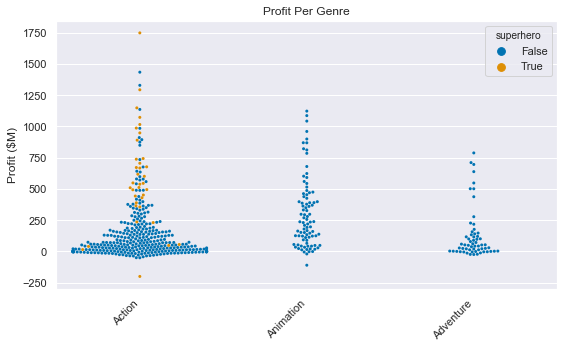

In [967]:
fig = plt.figure(figsize = (8, 5))

g = sns.swarmplot(x = 'genre', y = 'profit', hue = 'superhero', 
                  data = tripleAs, size = 3, palette="colorblind")

g.set(title = 'Profit Per Genre', 
      ylabel = "Profit ($M)", xlabel = "")

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

#fig.savefig("PNG/BLOG/profit_AAA_superhero.png")

plt.show()

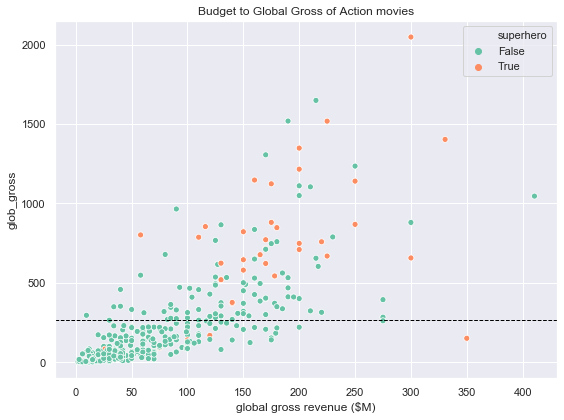

In [920]:
fig = plt.figure(figsize = (8, 6))

g = sns.scatterplot(x = 'budget', y = 'glob_gross', hue = 'superhero', 
               data = tripleAs[tripleAs.genre == "Action"], palette="Set2")

plt.axhline(tripleAs[tripleAs.genre == "Action"].glob_gross.mean(), ls='--', lw = 1, color = 'black')

g.set(title = "Budget to Global Gross of Action movies", xlabel ="global gross revenue ($M)")
plt.tight_layout()

#fig.savefig("PNG/BLOG/action_budget_glob_superhero.png")

plt.show()

Big chunk of high budget successes are superhero movies. Also, not depicted here, but looking at the dataset, it's also clear that most of successful non-superhero films are sequels. So it might be worth looking into if the success of first in series is related to the subsequent sequels more in action movies than other genres. 

In [969]:
temp

,genre,variable,value
0,Action,glob_gross,370.57
1,Action,glob_gross,1045.66
2,Action,glob_gross,757.89
3,Action,glob_gross,621.16
4,Action,glob_gross,494.87
...,...,...,...
1501,Adventure,budget,5.00
1502,Action,budget,6.00
1503,Action,budget,16.00
1504,Action,budget,3.00


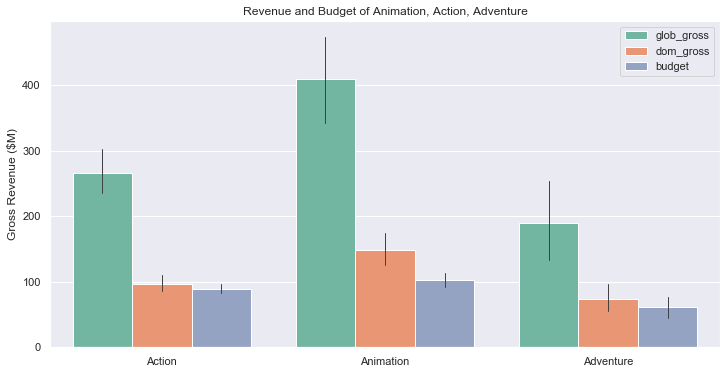

In [968]:
temp = pd.melt(tripleAs, id_vars=['genre'],
              value_vars=['glob_gross', 'dom_gross', 'budget'])

fig = plt.figure(figsize = (12,6))
g = sns.barplot(x="genre", y="value", hue="variable", data=temp, errwidth = 1, 
                palette="Set2")

g.set(title = "Revenue and Budget of Animation, Action, Adventure", ylabel = "Gross Revenue ($M)", xlabel = "")
plt.legend(title = "")

#fig.savefig("PNG/BLOG/AAA_Revenue_budget.png")

plt.show()


### Animation films with lower budget and high success

In [894]:
animation = df[df.genre == "Animation"]

In [895]:
synopsis = pd.read_csv('data/profit_data.csv', usecols = ['title', 'year', 'overview'])

In [896]:
import nltk

porter = nltk.PorterStemmer()
wnl = nltk.WordNetLemmatizer()

##================== STANDARDIZING =======================##  
import re

# Helper function to turn string into a list of lower case alphabet only words

def normalizing(string):
    """
    Input: string 
    Return: list of lower case keywords with special characters removed
    """
    return re.sub('[^A-Za-z]+', ' ', string).lower().split() 

##================== STOP WORDS =======================##  
# Importing stopwords from NLTK corpus 
from nltk.corpus import stopwords

## you may need to download the corpus to your drive:
## nltk.download('stopwords')

# We'll manually add couple more
sw = stopwords.words('english')
sw += ['p', 'r', 'l', 'x', 'e', 'h']

def remove_stop(list_):
    """
    Input: list of words
    Return: list of words excluding stopwords
    """
    return [x for x in list_ if x not in sw]
  
  
##================== ALL THINGS TOGETHER + AS LEMMA/STEM =======================##  
# Function to preprocess the word. Here we are using lemmatization, 
# then also porter stemming

import nltk

def make_keywords(string):
    """
    Input: string of words
    Return: list of words excluding stopwords (after normalizing) and lemmatized
    """
    wordslist = remove_stop(normalizing(string))
    return list(map(lambda x: porter.stem(wnl.lemmatize(x)), wordslist))

  
##================== APPLY FUNCTION =======================##  

synopsis['words'] = synopsis.overview.apply(lambda x: make_keywords(x))

In [897]:
# merge on title and year
animation = animation.merge(synopsis, how = 'left', on = ['title', 'year'])

In [917]:
from wordcloud import WordCloud

def count_words(list_):
    """
    input: list of preprocessed strings (refer to data preprocessing)
    output: dictionary of word counts for each unique words
    """
    # You can also use Counter from Collections package
    uniques = set(list_)
    counts = dict.fromkeys(uniques, 0)
    for word in list_:
        counts[word] += 1
    return {k: v for k, v in sorted(counts.items(), 
                                    reverse = True, key=lambda item: item[1])}
    
    
def plot_words(dict_, title, fname):
    """
    input: a dictionary of word counts, title of the graph (str), and a filename (str)
    output: barplot for first 30 words and wordcloud, and save out files
    """
    X = list(dict_.keys())[0:30]
    Y = list(dict_.values())[0:30]
    
    fig = plt.figure(figsize=(8, 6))
    
    ax = sns.barplot(x=X, y=Y, palette="Set2")
    ax.set(ylabel= 'counts', xlabel= '', title = title)
    ax.set_xticklabels(X, rotation=90) # rotate labels 90 degree
    
    plt.tight_layout() # make sure labels are not cropped in saved files
    plt.show()
    
    #fig.savefig(f"PNG/BLOG/{fname}.png")
    
    wc = WordCloud(background_color="white", width=600, height=400, max_words=50)
    wc.generate_from_frequencies(dict_)

    plt.imshow(wc, interpolation="bilinear")
    
    #wc.to_file(f"PNG/BLOG/{fname}_wc.png")
    
    plt.axis("off")
    plt.show()


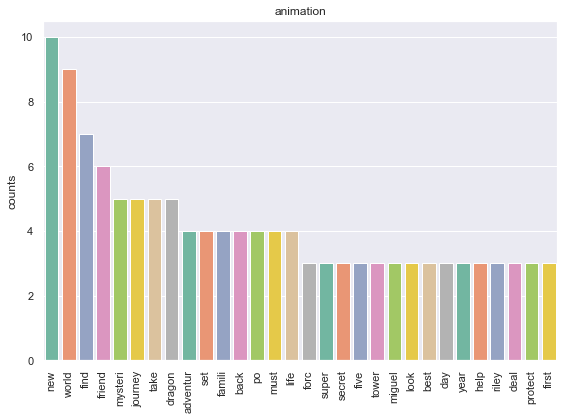

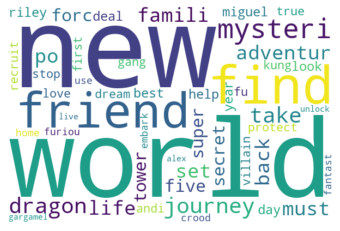

In [918]:
animation_overview = sum(animation[animation.glob_gross > animation.glob_gross.quantile(q = 0.75)]['words'], [])
plot_words(count_words(animation_overview), 'animation', 'animation')

# not much trend here.

## Award-worthy Film
So far we established that given high budget, animation is perhaps less risky genre to invest in than sequels and superhero dominated action. But we also need to invest in award-worthy films to establish the brand presence. Earlier we saw that biography and drama tend to get rated high. Let's see what type of biography or drama we can make without risking much loss.

### Ratings, Budget and Profit

In [902]:
awardfilms = df[df.genre.isin(['Biography', 'Drama'])]

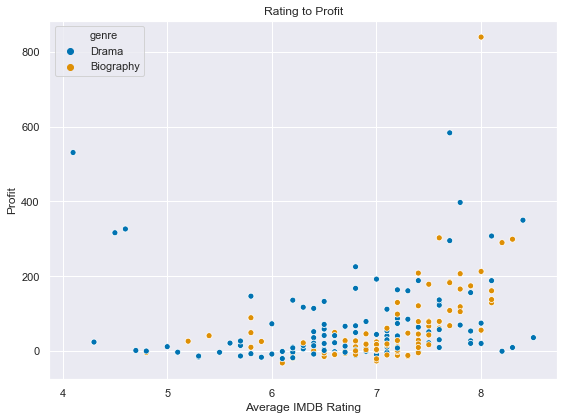

In [916]:
fig = plt.figure(figsize = (8, 6))

g = sns.scatterplot(x = 'avg_rating', y = 'profit', hue = 'genre', 
               data = awardfilms, palette="colorblind")

g.set(title = "Rating to Profit", xlabel ="Average IMDB Rating", ylabel = "Profit")
plt.tight_layout()

#fig.savefig("PNG/BLOG/rating_profit_drama_bio.png")

plt.show()

It seems like generally higher rating is associated with higher profit, but not by much. Also there seems to be some drama that are following different trajectory. Maybe it's worth looking at its sub-genres.

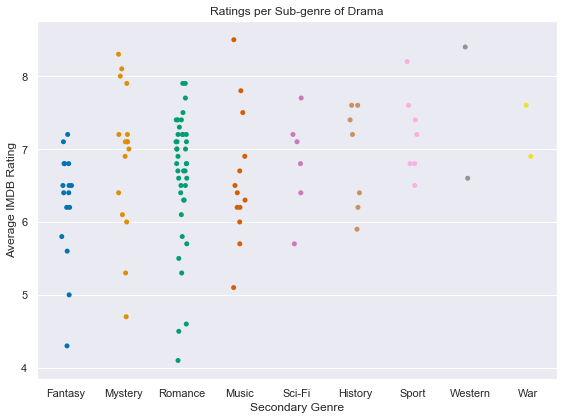

In [915]:
fig = plt.figure(figsize = (8, 6))

g = sns.stripplot(x = 'secondary_genre', y = 'avg_rating', 
               data = awardfilms[awardfilms.genre == "Drama"], palette="colorblind")

g.set(title = "Ratings per Sub-genre of Drama", xlabel = "Secondary Genre", ylabel = "Average IMDB Rating")
plt.tight_layout()

#fig.savefig("PNG/BLOG/drama_sub_genre_rating.png")

plt.show()

In [907]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols('avg_rating ~ C(secondary_genre)',data=awardfilms[awardfilms.genre == 'Drama']).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq     df         F    PR(>F)
C(secondary_genre)  8.130546   8.0    1.389927  0.210081
Residual            73.120280  100.0 NaN       NaN      


In [908]:
import scipy.stats as st

rating_t = st.ttest_ind(awardfilms[awardfilms.genre == 'Drama'].avg_rating, awardfilms[awardfilms.genre == 'Biography'].avg_rating)
profit_t = st.ttest_ind(awardfilms[awardfilms.genre == 'Drama'].profit, awardfilms[awardfilms.genre == 'Biography'].profit)
budget_t = st.ttest_ind(awardfilms[awardfilms.genre == 'Drama'].budget, awardfilms[awardfilms.genre == 'Biography'].budget)

print(f"rating: {round(rating_t[1],4)} \nprofit: {round(profit_t[1],4)} \nbudget: {round(budget_t[1],4)}")

rating: 0.0037 
profit: 0.9252 
budget: 0.7127


Difference in average IMDB rating between drama and biography is significant at the significance level of 0.05. (p < 0.01) But difference in profit or budget is not significant. So we should focus on making a biography film instead.


# Domestic vs. Global market
We saw earlier that potential of yielding large revenue with relatively lower budget is possible when targeting global market. Here, we will explore what are some of the key factors in such global success in animation film.

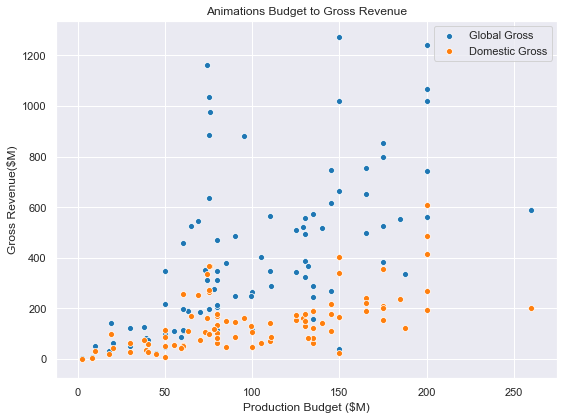

In [914]:
fig = plt.figure(figsize = (8, 6))

sns.scatterplot(x = 'budget', y = 'glob_gross', data = df[df.genre == 'Animation'], palette="colorblind", label = 'Global Gross')
sns.scatterplot(x = 'budget', y = 'dom_gross', data = df[df.genre == 'Animation'], palette="colorblind", label = 'Domestic Gross')

plt.title("Animations Budget to Gross Revenue")
plt.xlabel("Production Budget ($M)")
plt.ylabel("Gross Revenue($M)")
plt.tight_layout()

#fig.savefig("PNG/BLOG/animation_budget_gross.png")

plt.show()

Here I'll use the mean standardize score to compare domestic and global revenue on the same. 

In [910]:
df['glob_gross_z'] = (df['glob_gross'] - df['glob_gross'].mean())/df['glob_gross'].std()
df['dom_gross_z'] = (df['dom_gross'] - df['dom_gross'].mean())/df['dom_gross'].std()
df['budget_z'] = (df['budget'] - df['budget'].mean())/df['budget'].std()

In [911]:
top_animations = df[df.genre == 'Animation'].sort_values(by = ['profit'], ascending = False)

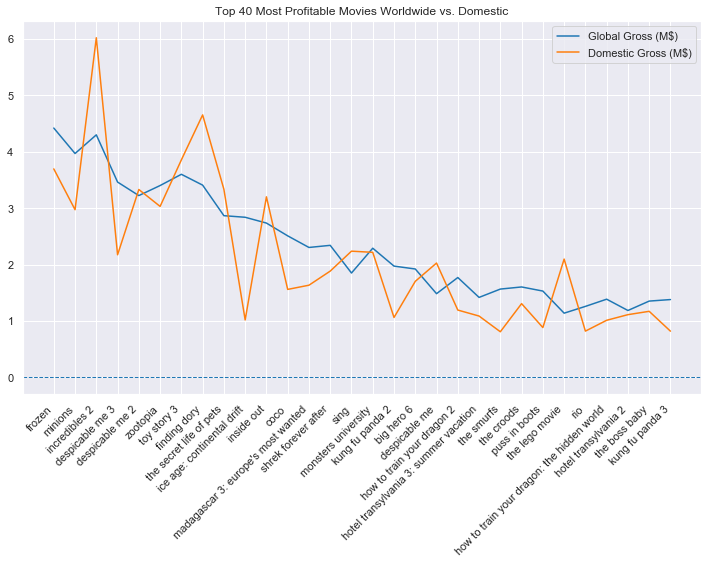

In [912]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(111)

sns.lineplot(x = 'title', y = 'glob_gross_z', 
             label = 'Global Gross (M$)', data = top_animations[0:30], sort = False, ax = ax1)
sns.lineplot(x = 'title', y = 'dom_gross_z', 
             label = 'Domestic Gross (M$)', data = top_animations[0:30], sort = False, ax = ax1)

#label = 'domestic gross',
ax1.set_xticklabels(labels = top_animations[0:30].title, rotation=45, ha = 'right')
ax1.axhline(0, ls='--', lw = 1)
plt.ylabel("")
plt.xlabel("")

plt.title("Top 40 Most Profitable Movies Worldwide vs. Domestic")
plt.legend()
plt.tight_layout()
plt.show()
#fig.savefig("PNG/Top30_Successful_Casts.png")

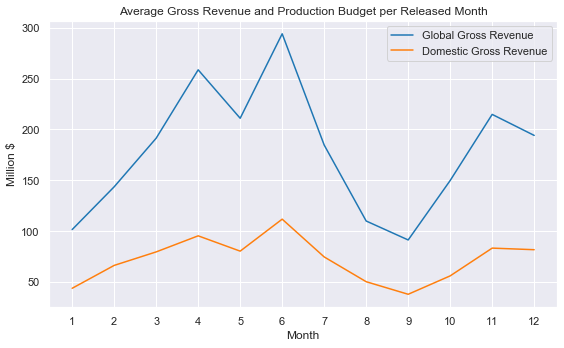

In [974]:
dom_gross_m = df.groupby('month').dom_gross.mean()
int_gross_m = df.groupby('month').glob_gross.mean()

fig = plt.figure(figsize = (8, 5))
sns.lineplot(data = int_gross_m, label = 'Global Gross Revenue', sort = False)
sns.lineplot(data = dom_gross_m, label = 'Domestic Gross Revenue', sort = False)

plt.ylabel("Million $")
plt.title("Average Gross Revenue and Production Budget per Released Month")
plt.xticks(list(range(1,13)))
plt.xlabel("Month")

plt.tight_layout()
#fig.savefig("PNG/BLOG/Average_Grossing_per_Release_Month.png")
plt.show()

